In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
large_noise_wave = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5).sample(1).samples.squeeze()
small_noise_wave = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.05, dof=5).sample(1).samples.squeeze()
noise_wave = np.r_[large_noise_wave, small_noise_wave]

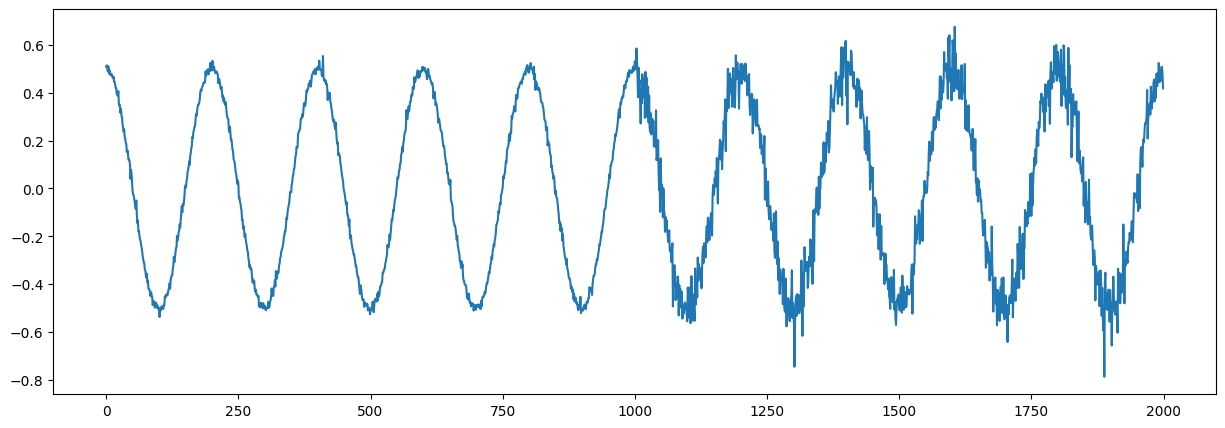

In [3]:
plt.figure(figsize=(15,5))
plt.plot(noise_wave)
plt.show()

In [8]:
class SineBinarySeparator(nn.Module):
    def __init__(self, input_dim=2000, output_dim=2000, dropout_p=.5):
        super(SineBinarySeparator, self).__init__()
        self.input = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        self.hidden = nn.Linear(output_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_p)
        self.output = nn.Linear(output_dim, input_dim)
        return
        
    def binarize(self, x, threshold=.5):
        binary_x = torch.where(x < threshold, torch.zeros_like(x), torch.ones_like(x))
        return binary_x.bool()
        
    def forward(self, x):
        self.dist_tensor = x
        x = self.input(x)
        x = self.activation(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        binary_x = self.binarize(x)
        return binary_x
    
    def loss(self, binary_x):
        self.class_a = self.dist_tensor[binary_x]
        self.class_b = self.dist_tensor[~binary_x]
        return self.class_a.var() - self.class_b.var()
    
    def configure_optimizer(self, **kwargs):
        optimizer = torch.optim.RMSprop(self.parameters(), **kwargs)
        return optimizer
    
    def train(self, x, epochs=1000):
        if not hasattr(self, 'loss_items'):
            self.loss_items = list()
        optimizer = self.configure_optimizer()
        for epoch in range(epochs):
            optimizer.zero_grad()
            binary_x = self.forward(x)
            loss = self.loss(binary_x)
            loss.backward()
            optimizer.step()
            self.loss_items.append(loss.item())
        return
            
    def plot_loss(self, step=1, title=''):
        plt.figure(figsize=(16,8))
        sns.lineplot(self.loss_items[::step], dashes=False, palette='Spectral', label='Variance Difference Loss')
        plt.title(title)
        plt.legend()
        plt.show()
        return

In [9]:
wave_tensor = torch.from_numpy(noise_wave).double()

model = SineBinarySeparator(input_dim=wave_tensor.shape[0]).double()
model.train(wave_tensor, epochs=100)
model.plot_loss()
model.train(wave_tensor, epochs=100)
model.plot_loss()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn